In [2]:
import logging
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import elfi
from sim.utils import ScaledDist, plot_dist
from sim.model import elfi_sim
from sim.sum_stats import elfi_sum, elfi_sum_scaler
import scipy.stats
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

elfi.set_client("multiprocessing")

In [25]:
dist = np.load("../output/distances.npy")

In [16]:
x = np.linspace(0,0.1,20)
y = np.quantile(dist, x)

In [36]:
np.quantile(dist, 0.001)

12.703273291299773

In [29]:
1/500

0.002

In [39]:
dist

array([12.26847364, 13.13981562, 13.51433706, 14.08415743, 14.51698531,
       14.52160036, 14.65530889, 14.73955439, 14.82771983, 14.86274315,
       14.9299145 , 15.00753902, 15.04833658, 15.07687844, 15.15884383,
       15.17575537, 15.22759793, 15.24647109, 15.30529367, 15.42727627,
       15.47810068, 15.48577564, 15.49738441, 15.50818866, 15.51466235,
       15.56308201, 15.57742134, 15.59213036, 15.59481576, 15.60997499,
       15.61401535, 15.61838091, 15.62672053, 15.68244481, 15.75485875,
       15.75863041, 15.79509722, 15.83233372, 15.87561423, 15.88057041,
       15.94319059, 15.94979648, 15.95599259, 15.97864399, 15.98613626,
       16.00138923, 16.00747852, 16.0205815 , 16.02836096, 16.04732545,
       16.16150804, 16.16156695, 16.16536213, 16.18013267, 16.19798378,
       16.2002343 , 16.21152415, 16.22205705, 16.24106333, 16.26562462,
       16.29750389, 16.32911283, 16.3737671 , 16.37831933, 16.37867248,
       16.40231283, 16.44773398, 16.46802304, 16.48559604, 16.48

Text(0.5, 0, 'Quantile')

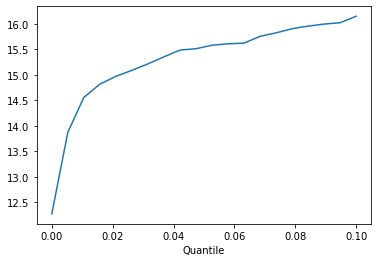

In [17]:
plt.plot(x, y)
plt.xlabel("Quantile")

In [19]:
400/1398

0.2861230329041488

In [21]:
400/0.02

20000.0

In [93]:
# Approximate needed time
n_sim_needed = 500 * ((1/0.025) + (1/0.09) + (1/0.2))
hours_per_sim = 17.5/60
n_cores = 256

In [94]:
request_time = (n_sim_needed*hours_per_sim)/n_cores

In [95]:
request_time

31.964337384259263

In [15]:
500*(1/0.25) + 500*(1/0.2) 

4000.0

In [23]:
with open("../data/e3_phased.pkl", "rb") as f:
    y_obs = np.atleast_2d(pickle.load(f))

In [16]:
import time
import logging
import numpy as np
import elfi
from sim.model import elfi_sim
from sim.sum_stats import elfi_sum, elfi_sum_scaler
import pickle
from sklearn.preprocessing import StandardScaler

job_start_time = time.time()

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

seq_length = 44648284  # E3 length is 44648284
train_scaler_n_sim = 60
rej_n_sim = 60

logging.info(f"Seq length is set to {seq_length}")

#num_cores = 0
#timeout = time.time() + 600  # seconds
#while num_cores is 0:
#    elfi.set_client("ipyparallel", profile="pbs")  # Assumes ipython profile named pbs
#    c = elfi.client.get_client()
#    num_cores = c.num_cores
#    if time.time() > timeout:
#        raise TimeoutError("Could not find any cores after 600 seconds")
#    time.sleep(10)

#logging.info(f"Ipyparallel client started with {num_cores} cores.")

with open("../output/priors.pkl", "rb") as f:  # Priors specified in priors.py
    priors = pickle.load(f)

with open("../data/e3_phased.pkl", "rb") as f:
    y_obs = np.atleast_2d(pickle.load(f))

# Set up elfi model
m = elfi.ElfiModel("m")

elfi.Constant(seq_length, name="length", model=m)
elfi.Constant(1.8e-8, name="recombination_rate", model=m)
elfi.Constant(6e-8, name="mutation_rate", model=m)

for prior_name, prior in priors.items():
    elfi.Prior(prior.sampling, name=prior_name, model=m)

prior_args = [m[name] for name in m.parameter_names]

elfi.Simulator(elfi_sim, *prior_args, m["length"], m["recombination_rate"],
               m["mutation_rate"], priors, name="sim", model=m, observed=y_obs)

elfi.Summary(elfi_sum, m["sim"], None, name="sum", model=m)
elfi.Operation(elfi_sum_scaler, m["sum"], None, name="sum_scaler")  # Placeholder (no scaling yet)
elfi.Distance('euclidean', m["sum_scaler"], name='d', model=m)

INFO:root:Seq length is set to 44648284


Distance(name='d')

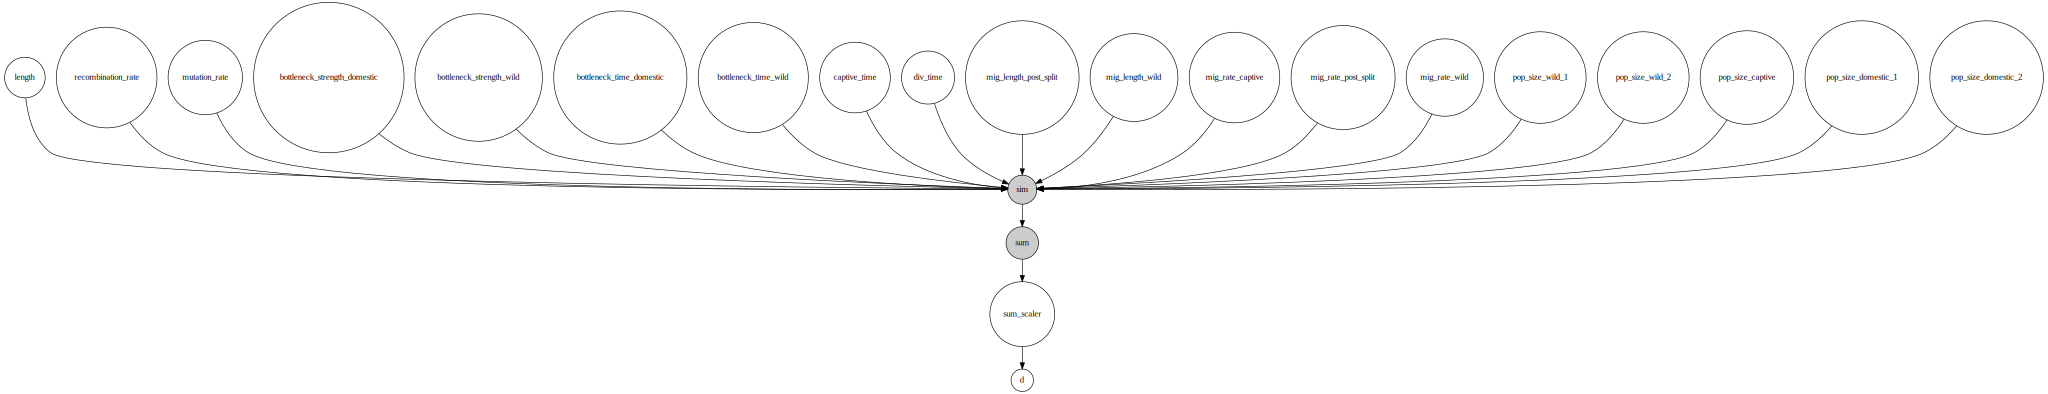

In [17]:
elfi.draw(m)

In [15]:
rej = elfi.Rejection(m['d'], batch_size=1, seed=2)
rej_res = rej.sample(1, quantile=1, bar=True)  # Accept all

TimeoutError: Hub connection request timed out

In [3]:
with open ("../output/priors.pkl", "rb") as f:
    priors = pickle.load(f)
    
with open ("../data/e3_phased.pkl", "rb") as f:
    obs_sum = elfi_sum(np.atleast_2d(pickle.load(f)))

### Set up elfi model

In [6]:
elfi.new_model()
m = elfi.ElfiModel("m")

elfi.Constant(int(5e6), name="length", model=m)
elfi.Constant(1.8e-8, name="recombination_rate", model=m)
elfi.Constant(6e-8, name="mutation_rate", model=m)

for prior_name, prior in priors.items():
    elfi.Prior(prior.sampling, name=prior_name, model=m)

prior_args = [m[name] for name in m.parameter_names]

elfi.Simulator(elfi_sim, *prior_args, m["length"], m["recombination_rate"],
               m["mutation_rate"], priors, name="sim", model=m)
elfi.Summary(elfi_sum, m["sim"], None, name="sum", model=m, observed=obs_sum)
elfi.Operation(elfi_sum_scaler, m["sum"], None, name="sum_scaler")  # Placeholder (no scaling)
elfi.Distance('euclidean', m["sum_scaler"], name='d', model=m)

# m.observed = {"sim_sum": elfi_summary(np.atleast_2d(y_obs))}

Distance(name='d')

In [ ]:
import time
elfi.set_client("native")
for client in ["multiprocessing", "native"]:
    elfi.set_client(client)
    results = []
    for i in range(2):
        start_time = time.time()
        m["sim_sum"].generate(2)
        elapsed_time = time.time() - start_time
        results.append(elapsed_time)
    print(f"With client {client} the mean elapsed time was {np.mean(results)}s")


In [ ]:
elfi.set_client("multiprocessing")
results = []
for i in range(1):
    start_time = time.time()
    m["sim_sum"].generate(4)
    elapsed_time = time.time() - start_time
    results.append(elapsed_time)
print(f"With client {client} the mean elapsed time was {np.mean(results)}s")

In [ ]:
elfi.draw(m)

In [ ]:
%%time
elfi.set_client("multiprocessing")

pool = elfi.OutputPool(['sim_sum'])
rej = elfi.Rejection(m['d'], batch_size=1, seed=1, pool=pool)
rej.sample(4, quantile=1, bar=True)  # Accept all
store = pool.get_store('sim_sum')
sum_stats = np.array(list(store.values()))
sum_stats = sum_stats.reshape(-1, sum_stats.shape[2])  # Drop batches axis
scaler = StandardScaler()
scaler.fit(sum_stats)


### Generate summary stats to train scaler

In [ ]:
sum_stats = m["sim_sum"].generate(10)
scaler = StandardScaler()
scaler.fit(sum_stats)
m["sum_scaler"].become(elfi.Summary(elfi_sum_scaler, m["sim_sum"], scaler, model=m))

In [ ]:
test = m["sum_scaler"].generate(1)
print(f"Sum stats generated have mean of {test.mean()} and a standard deviation of {test.std()}")

### Carry out simulations to "train" sum stat scaler

In [ ]:
seed = 1
pool = elfi.OutputPool(['s'])
rej = elfi.Rejection(m['d'], batch_size=4, seed=1, pool=pool)
rej_res = rej.sample(3, quantile=1, bar=False)  # Accept all
store = pool.get_store('s')
sum_stats = np.array(list(store.values()))
sum_stats = sum_stats.reshape(-1, sum_stats.shape[2])  # Drop batches axis
scaler = StandardScaler()
scaler.fit(sum_stats)
m["s"].become(elfi.Summary(elfi_summary, y, scaler, False, name='s_scaled', model=m))  # Scaler and quick_mode

In [ ]:
%%time
d.generate(5)

### SMC

In [ ]:
dists = m['d'].generate(20)

In [ ]:
dists

In [ ]:
%%time
logging.getLogger().setLevel(logging.INFO)
smc = elfi.SMC(m['d'], batch_size=5, seed=1)
N = 500
schedule = [12, 11, 10, 9]
result_smc = smc.sample(N, schedule)
result_smc.summary(all=True)

### Collect and write out results

In [ ]:
samples = result_smc.samples_array
weights = result_smc.weights

In [ ]:
results = pd.DataFrame(samples, columns=sorted(priors.keys()))
results["weights"] = result_smc.weights

# scale back up results
for name, dist in scaled_priors.items():
    results[name] = dist.scale_up_samples(results[name])
    
results.to_csv("../output/smc_posterior.csv", index=False)

In [ ]:
# Write out pdfs

df_list = []

for name, dist in priors.items():
    if isinstance(dist, ScaledDist):
        dist = dist.target
    x_lims = dist.ppf([0.001, 0.999])
    x = np.linspace(x_lims[0], x_lims[1], 1000)
    y = dist.pdf(x)
    df = pd.DataFrame({"x": x, "parameter": name, "value": y})
    df_list.append(df)
    
pdf_df = pd.concat(df_list)
pdf_df.to_csv("../output/prior_pdf.csv", index=False)